# Environment Setup

In [ ]:
!nvidia-smi

Mon Oct 28 05:34:15 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:21:00.0 Off |                  Off |
| 30%   42C    P8             18W /  450W |       1MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# !pip install datasets

In [ ]:
# !pip install torch
# !pip install transformers
# !pip install accelerate
# !pip install matplotlib
# !pip install wandb
# !pip install transformers

In [ ]:
base_model_id = "microsoft/Phi-3.5-mini-instruct"
data_id = "AlanYky/tweets_instruct"

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig

torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
    attn_implementation="flash_attention_2",
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id)

model.to("cuda")

config.json:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-mini-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-mini-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3FlashAttention2(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=307

In [ ]:
from datasets import load_dataset, concatenate_datasets
import torch
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig
import os
import matplotlib.pyplot as plt
import wandb
import transformers
from datetime import datetime
import logging
from tqdm import tqdm
from collections import Counter

# Util Functions

In [ ]:
def generate_tweet(instruction, pipe, generation_args):
    # Prepare the messages structure
    messages = [
        # {
        #     "role": "system",
        #     "content": "You are a creative assistant skilled at writing human-like tweets. Respond only with the tweet text."
        # },
        {
            "role": "user",
            "content": instruction
        }
    ]

    # Generate the tweet response
    output = pipe(messages, **generation_args)

    # Extract and return the generated tweet text
    return output[0]['generated_text']


def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) if len(x['input_ids'])<1024 else 1024 for x in tokenized_train_dataset ]
    lengths += [len(x['input_ids']) if len(x['input_ids'])<1024 else 1024 for x in tokenized_val_dataset]
    print(len(lengths))
    print("Max length: ", max(lengths))

    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

def formatting_func(example):
    instruction = example['instruction']
    tweet = example['text']
    return f"<|endoftext|><|user|>\n{instruction} <|end|>\n<|assistant|>\n{tweet}"

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))



# Tokenize Data

In [ ]:
train_dataset = load_dataset(data_id)

README.md:   0%|          | 0.00/762 [00:00<?, ?B/s]

(…)le_event_instruct-00000-of-00001.parquet:   0%|          | 0.00/2.59M [00:00<?, ?B/s]

topic_instruct-00000-of-00001.parquet:   0%|          | 0.00/685k [00:00<?, ?B/s]

general_instruct-00000-of-00001.parquet:   0%|          | 0.00/5.21M [00:00<?, ?B/s]

tones_instruct-00000-of-00001.parquet:   0%|          | 0.00/6.38M [00:00<?, ?B/s]

Generating people_event_instruct split:   0%|          | 0/22174 [00:00<?, ? examples/s]

Generating topic_instruct split:   0%|          | 0/6067 [00:00<?, ? examples/s]

Generating general_instruct split:   0%|          | 0/94035 [00:00<?, ? examples/s]

Generating tones_instruct split:   0%|          | 0/78184 [00:00<?, ? examples/s]

In [ ]:
train_dataset

DatasetDict({
    people_event_instruct: Dataset({
        features: ['instruction', 'text'],
        num_rows: 22174
    })
    topic_instruct: Dataset({
        features: ['instruction', 'text'],
        num_rows: 6067
    })
    general_instruct: Dataset({
        features: ['instruction', 'text'],
        num_rows: 94035
    })
    tones_instruct: Dataset({
        features: ['instruction', 'text'],
        num_rows: 78184
    })
})

In [ ]:
combined_dataset = concatenate_datasets([train_dataset[subset] for subset in train_dataset])
combined_dataset

Dataset({
    features: ['instruction', 'text'],
    num_rows: 200460
})

In [ ]:
# Shuffle the combined dataset
shuffled_dataset = combined_dataset.shuffle(seed=42)
shuffled_dataset

Dataset({
    features: ['instruction', 'text'],
    num_rows: 200460
})

In [ ]:
# Split the dataset
first_100k_dataset = shuffled_dataset.select(range(100000))  # First 100,000 samples
remaining_dataset = shuffled_dataset.select(range(100000, len(shuffled_dataset)))  # Remaining samples

In [ ]:
first_100k_dataset

Dataset({
    features: ['instruction', 'text'],
    num_rows: 100000
})

In [ ]:
remaining_dataset

Dataset({
    features: ['instruction', 'text'],
    num_rows: 100460
})

In [ ]:
# Save the datasets locally (optional) or push directly to Hugging Face
first_100k_dataset.push_to_hub("AlanYky/tweets_instruct_100k_1")
remaining_dataset.push_to_hub("AlanYky/tweets_instruct_100k_2")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/100 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/101 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/AlanYky/tweets_instruct_100k_2/commit/281f40295b6d00120df505d342848fd9bce1c771', commit_message='Upload dataset', commit_description='', oid='281f40295b6d00120df505d342848fd9bce1c771', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/AlanYky/tweets_instruct_100k_2', endpoint='https://huggingface.co', repo_type='dataset', repo_id='AlanYky/tweets_instruct_100k_2'), pr_revision=None, pr_num=None)

In [ ]:
# Split into training and validation datasets
validation_dataset = first_100k_dataset.select(range(5))  # First 10 samples for validation
training_dataset = first_100k_dataset.select(range(5, len(first_100k_dataset)))  # Rest for training

# Print the 10 samples in the validation dataset
for i, sample in enumerate(validation_dataset):
    print(f"Sample {i+1}:", sample)
    print("\n")

Sample 1: {'instruction': 'Can you write a tweet with a controversial tone?', 'text': 'Paying a docotor to perform euthanasia just takes a lot of money and a little persuasion'}


Sample 2: {'instruction': 'Can you write a tweet with a casual tone?', 'text': "Please tell me you're going in Celebrity Big Brother on Thursday."}


Sample 3: {'instruction': 'Can you generate a tweet?', 'text': ' *feels sorry for self* lol '}


Sample 4: {'instruction': 'Can you write a tweet with a controversial tone?', 'text': 'Good one Bob! Show her who the real boss is! And keep up the support for our cause.'}


Sample 5: {'instruction': 'Can you write a tweet to me?', 'text': " good morning! will be hot and humid here in SC! i'll send u some warm air for this morning "}


In [ ]:
tokenized_train_dataset = training_dataset.map(
    generate_and_tokenize_prompt,
    num_proc=os.cpu_count(),
)

tokenized_val_dataset = validation_dataset.map(
    generate_and_tokenize_prompt,
    num_proc=os.cpu_count(),
)

Map (num_proc=64):   0%|          | 0/99995 [00:00<?, ? examples/s]

num_proc must be <= 5. Reducing num_proc to 5 for dataset of size 5.


Map (num_proc=5):   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
tokenizer.decode(tokenized_train_dataset[1]["input_ids"])

"<|endoftext|><|user|> Generate a tweet about Gosling. <|end|><|assistant|> Gosling you're not a trojan horse. I dont see how your presence is a detriment to Black Glory. 😎"

100000
Max length:  437


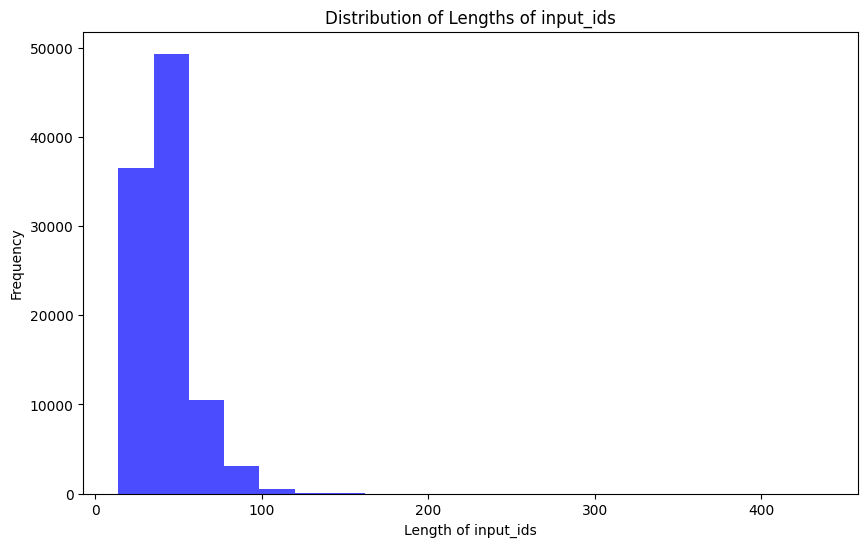

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt_padding(prompt):
    result = tokenizer(
        formatting_func(prompt),
        max_length=250,
        truncation=True,
        padding='max_length',
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = training_dataset.map(
    generate_and_tokenize_prompt_padding,
    num_proc=os.cpu_count(),)

tokenized_val_dataset = validation_dataset.map(
    generate_and_tokenize_prompt_padding,
    num_proc=os.cpu_count(),)

Map (num_proc=64):   0%|          | 0/99995 [00:00<?, ? examples/s]

num_proc must be <= 5. Reducing num_proc to 5 for dataset of size 5.


Map (num_proc=5):   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_dataset = tokenized_train_dataset.remove_columns(
    training_dataset.column_names
)

tokenized_val_dataset = tokenized_val_dataset.remove_columns(
    validation_dataset.column_names
)


100000
Max length:  250


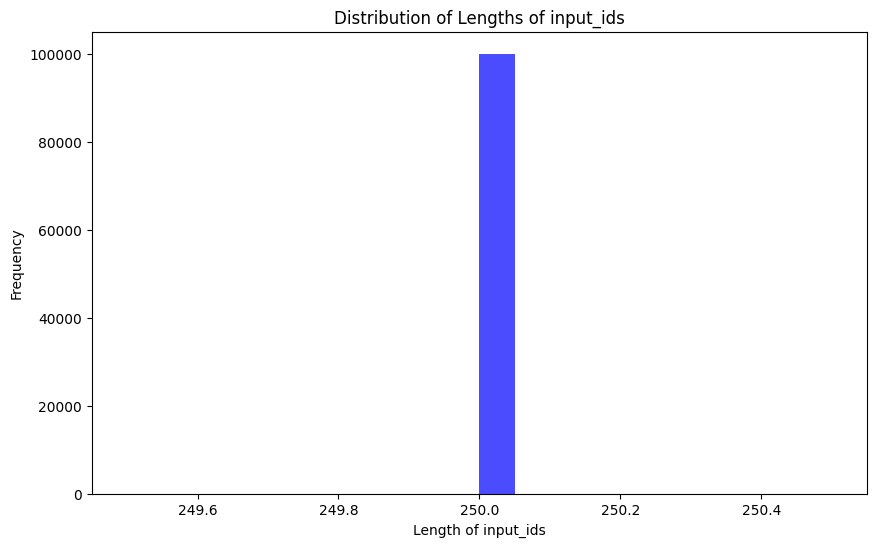

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
len(tokenized_train_dataset[1]["input_ids"])

250

In [ ]:
tokenizer.decode(tokenized_train_dataset[40]["input_ids"])

"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext

# Base Model Performance

In [ ]:
tweet_generation_prompt = "Can you generate the tweet about NBA"

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

generate_tweet(
    instruction=tweet_generation_prompt,
    pipe=pipe,
    generation_args=generation_args
)

/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48


' "🏀 Thrilling NBA action continues! Witness the powerhouse plays, incredible teamwork, and electrifying energy as top athletes showcase their skills on the court. From dazzling dunks to strategic plays, every moment is a testament to the love of basketball. #NBA #BasketballBliss #GameDayExcitement"'

# Tweets Instruction Tuning

In [ ]:
# bd989240e730a8a990308fd969e1a2478fad8371
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  # Use both GPUs

In [ ]:
logging.getLogger("transformers").setLevel(logging.DEBUG)
os.environ["WANDB_PROJECT"]="phi35-tweet"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

In [ ]:
run_name = "phi3_2"
output_dir = "./" + run_name

In [ ]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset.select(range(1)),
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        num_train_epochs=1,
        output_dir=output_dir,
        warmup_steps=1,
        gradient_accumulation_steps=1,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="no",               # Disable checkpoint saving
        # save_steps=1,
        # save_total_limit = 1,                     # Mixed precision for efficiency
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=100,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/opt/conda/lib/python3.11/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
You have loaded a model on multiple GPUs. `is_model_parallel` attribute will be force-set to `True` to avoid any unexpected behavior such as device placement mismatching.
Currently training with a batch size of: 1
***** Running training *****
  Num examples = 99,995
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 99,995
  Number of trainable parameters = 3,821,079,552
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


wandb: Currently logged in as: yangkaiyam (alanyang5114). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
100,2.273200,2.093099


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


Step,Training Loss,Validation Loss
100,2.273200,2.093099
200,2.292600,2.106392
300,2.396100,2.124520
400,2.486400,2.076695
500,2.402600,2.105610
600,2.315000,2.135811
700,2.546100,2.123033
800,2.368600,2.158204
900,2.444900,2.143856
1000,2.396400,2.142466


In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          91G  9.8G   82G  11% /
tmpfs            64M     0   64M   0% /dev
shm              15G  4.0K   15G   1% /dev/shm
/dev/loop17     3.1T  1.2T  2.0T  37% /etc/hosts
/dev/sda2       3.5T  1.3T  2.1T  39% /usr/bin/nvidia-smi
tmpfs           126G   12K  126G   1% /proc/driver/nvidia
tmpfs           126G  4.0K  126G   1% /etc/nvidia/nvidia-application-profiles-rc.d
tmpfs            26G   18M   26G   1% /run/nvidia-persistenced/socket
tmpfs           126G     0  126G   0% /proc/asound
tmpfs           126G     0  126G   0% /proc/acpi
tmpfs           126G     0  126G   0% /proc/scsi
tmpfs           126G     0  126G   0% /sys/firmware
tmpfs           126G     0  126G   0% /sys/devices/virtual/powercap


In [ ]:
wandb.finish()

# Tuned Model Performance

In [ ]:
tweet_generation_prompt = "Generate the tweet about NBA"

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 200,
    "return_full_text": False,
    "temperature": 0.7,            # Add some randomness
    "top_p": 0.9,                  # Use nucleus sampling to filter out low-probability tokens
    "repetition_penalty": 1.2,     # Penalize repeated tokens to avoid loops
    "do_sample": True,             # Enable sampling
}

generate_tweet(
    instruction=tweet_generation_prompt,
    pipe=pipe,
    generation_args=generation_args
)


# ' "🏀 Thrilling NBA action continues! Witness the powerhouse plays, incredible teamwork, and electrifying energy as top athletes showcase their skills on the court. From dazzling dunks to strategic plays, every moment is a testament to the love of basketball. #NBA #BasketballBliss #GameDayExcitement"'

" The Lakers may not be winning yet but they're going to end up with a 3rd place team in the West. As long as LeBron James is on the court, we can win! #NBA2021 #LALAZERYSTARS #LAKERS #DENVERJUSTICEFANS#DELTATWITCHES#GOLDGLADIACSFINALLYGETTINGREUNITE  🏀⚽️🥅🥍🏐🏒⚾️🏹⛳️❄️🏔️🌲🌺🍃🌞🌙💭🗣️🤠🦁👨\u200d👩\u200d👧\u200d��"

In [ ]:
model.push_to_hub("AlanYky/phi-3.5_tweets_instruct")

Configuration saved in /tmp/tmpbz9v33wc/config.json
Configuration saved in /tmp/tmpbz9v33wc/generation_config.json
The model is bigger than the maximum size per checkpoint (5GB) and is going to be split in 2 checkpoint shards. You can find where each parameters has been saved in the index located at /tmp/tmpbz9v33wc/model.safetensors.index.json.
Uploading the following files to AlanYky/phi-3.5_tweets_instruct: config.json,generation_config.json,model-00001-of-00002.safetensors,model-00002-of-00002.safetensors,model.safetensors.index.json,README.md


model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AlanYky/phi-3.5_tweets_instruct/commit/afbe5fc34dd90188165d41e2956fff9d52b06098', commit_message='Upload Phi3ForCausalLM', commit_description='', oid='afbe5fc34dd90188165d41e2956fff9d52b06098', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AlanYky/phi-3.5_tweets_instruct', endpoint='https://huggingface.co', repo_type='model', repo_id='AlanYky/phi-3.5_tweets_instruct'), pr_revision=None, pr_num=None)